# 5. Criação de Modelos de Machine Learning

## Carregar dados tratados

In [34]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

import joblib

In [36]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

## Feature selection

In [37]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar

In [38]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\n{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}\n")

    return X_treino, X_teste, y_treino, y_teste

# ML modelos

## Modelos a serem testados

- AdaBoost
- Gradient Boost
- Rede Neural

In [39]:
def definir_modelos_ml() -> dict:
    modelos = {
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42),
        "LogisticRegression": LogisticRegression(random_state=42),
    }
    print(f"\nModelos a serem comparados: {[v for v in modelos.keys()]}\n")
    return modelos

In [40]:
def treinar_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    modelo_acuracia = {}
    for nome, modelo in modelos.items():
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        
        modelo_acuracia[nome] = avaliar(y_teste, previsoes, f"{nome} Teste")
        modelos[nome] = modelo
    
    return modelo_acuracia

In [41]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [42]:
def avaliar(y_teste, y_pred, nome_modelo):
    print(nome_modelo)
    
    report = classification_report(y_teste, y_pred, target_names=["Vender", "Comprar"])
    print(report)
    
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_pred), 
                             index=["Vender", "Comprar"], 
                             columns=["Vender", "Comprar"])
    
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    
    print("Precision:", metrics.precision_score(y_teste, y_pred))
    print("#" * 50)
    return metrics.precision_score(y_teste, y_pred)

In [43]:
def modelos_com_melhores_scores(modelos : dict):
    sort_orders = sorted(modelos.items(), key=lambda x: x[1], reverse=True)
    print(f"Modelos x Precision: {sort_orders[:3]}")

# Execucao

Carregado df com 1852 linhas e 6 colunas.

Colunas carregadas: ['outros_ativos_circ', 'receita_liq', 'despesas_gerais', 'resultado_antes_trib', 'lucro_op', 'decisao']



len(X_treino)=1481 len(X_teste)=371 len(y_treino)=1481 len(y_teste)=371

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

Modelos a serem comparados: ['DecisionTreeClassifier', 'RandomForest', 'LogisticRegression']

DecisionTreeClassifier Teste
              precision    recall  f1-score   support

      Vender       0.49      0.50      0.50       186
     Comprar       0.49      0.48      0.49       185

    accuracy                           0.49       371
   macro avg       0.49      0.49      0.49       371
weighted avg       0.49      0.49      0.49       371

(2, 2)


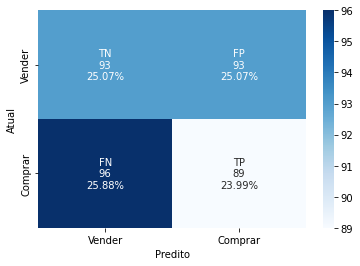

Precision: 0.489010989010989
##################################################
RandomForest Teste
              precision    recall  f1-score   support

      Vender       0.54      0.51      0.52       186
     Comprar       0.53      0.56      0.54       185

    accuracy                           0.53       371
   macro avg       0.53      0.53      0.53       371
weighted avg       0.53      0.53      0.53       371

(2, 2)


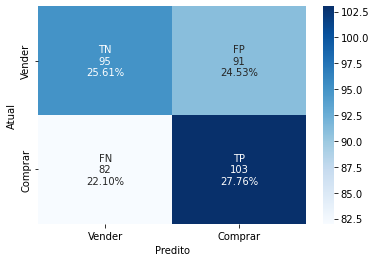

Precision: 0.5309278350515464
##################################################
LogisticRegression Teste
              precision    recall  f1-score   support

      Vender       0.57      0.57      0.57       186
     Comprar       0.57      0.57      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


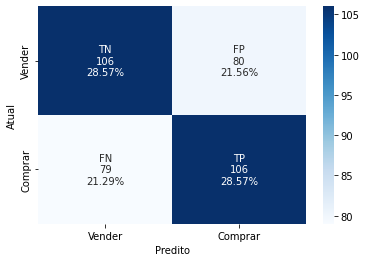

Precision: 0.5698924731182796
##################################################
Modelos x Recall: [('LogisticRegression', 0.5698924731182796), ('RandomForest', 0.5309278350515464), ('DecisionTreeClassifier', 0.489010989010989)]


In [44]:
def main():

    df = carregar_joblib()

    print(f"Carregado df com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")
    print(f"Colunas carregadas: {[col for col in df.columns]}\n\n")

    # split database 25% test 75% train
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    print("#-" * 40)

    modelos = definir_modelos_ml()

    modelos_acc = treinar_modelos_ml(modelos, X_treino.values, X_teste.values, y_treino.values, y_teste.values)

    modelos_com_melhores_scores(modelos_acc)

    return df

df = main()

## 3 Melhores modelos - precision

- AdaBoost - 60,11%
- RandomForest - 59,84%
- GradientBoost - 59,25%
